<a href="https://colab.research.google.com/github/Olivia-Feldman/NUGAN-DISTGAN/blob/Olivia/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

# Investigating and visualizing Mode Collapse in the MNIST dataset 

#What is mode collpase? 

mode collapse occurs when the generator is only generating a small  diversity of modes(digits).


#Why can it occur? 

 The generator learns to map several different input z values to the same output point. 

#How to identify mode collapse? 

Mode collapse can be identified by reviewing a large samples of generated images and looking for common signs of mode collapse:

   - low diversity of digits (reapting images of ones ) 

Looking at a line plot of the model loss in the generator: 
    - As the generator model is updated the loss should oscillate between different modes. 
    
#MNIST Dataset 
To visualize mode collapse in the MNIST dataset we will compare generated images from a gan model using a latent variable of 100 and a gan model using a latnet variable of 1. This is to restrict the size of the latent dimension to force the model to generate a small diversity of images. 
  

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Loading in the MNIST dataset


In [3]:
# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [4]:
print(train_dataset.data.shape)

torch.Size([60000, 28, 28])


In [5]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [6]:
def visualize_results(gan):
      sample_z_ = torch.rand((10, gan.z_dim)).cuda()
      samples = gan.G(sample_z_)
      samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
      samples = (samples + 1) / 2
      plt.figure(figsize=((1,10)))
      fig,ax = plt.subplots(1,10)
      for i in range(10):
        s=ax[i].imshow(np.squeeze(samples[i,]))
        s=ax[i].get_xaxis().set_visible(False)
        s=ax[i].get_yaxis().set_visible(False)
      s=plt.show()

In [7]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, input_size=28, base_size=128):
        super(Generator, self).__init__()  
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = 28
        self.base_size = base_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(2*self.base_size, self.base_size, 4, 2, 1),
            nn.BatchNorm2d(self.base_size),
            nn.ReLU(),
            nn.ConvTranspose2d(self.base_size, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )

        initialize_weights(self)           
    
    # forward method
    def forward(self, x): 
       # x = x.view(-1, self.input_size * self.input_size)
        x = self.fc(x)
        x = x.view(-1, 2*self.base_size, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)
        return x



class Discriminator(nn.Module):
  def __init__(self, input_dim, output_dim, input_size=28, base_size=128):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size


        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, 4, 2, 1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(2*self.base_size * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )

        initialize_weights(self)

     # forward method
  def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x

#Building a GAN model 

In [8]:

class GAN():
    def __init__(self,params):
        # parameters
        self.epoch = params['max_epochs']
        self.sample_num = 100
        self.batch_size = 128
        self.input_size = 28
        self.z_dim = params['z_dim']
        self.base_size = params['base_size']

        # load dataset
        self.data_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        data = self.data_loader.__iter__().__next__()[0]



        # initialization of the generator and discriminator
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size,base_size=self.base_size).cuda()
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size,base_size=self.base_size).cuda()
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        
        # initialization of the loss function
        #self.BCE_loss = nn.SmoothL1Loss(beta=0.9)
        self.BCE_loss = nn.BCELoss().cuda()
        self.BCE_loss = nn.MSELoss()
        
        # Gettng a batch of noise to generate the fake data
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim)).cuda()
        
# Fucntion to train the GAN, where you alternate between the training of the genenator and discriminator
#--------------------------------------------------------------------------------------------------------

    def train(self):

       # Setting empty arrays for storing the losses

        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        # Setting up the labels for real and fake images
        self.y_real_, self.y_fake_ = torch.ones(self.batch_size,1).fill_(0.9).type(torch.float32).cuda(), torch.zeros(self.batch_size, 1).cuda()
        
        print('training start!!')

        # Epoch loops

        for epoch in range(self.epoch):
            epoch_start_time = time.time()


            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                # Generate random noise to push through the generator   

                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()
               # x_ = x_.view(x_.size(0),-1)
                #z_ = z_.view(z_.size(0),-1)
                

         

                # update D network using 
                # 1. Set optimizer gradient to zero
                gan.D_optimizer.zero_grad()
                
                D_real = gan.D(x_)

                
                D_real_loss = gan.BCE_loss(D_real, gan.y_real_ )
                G_ = gan.G(z_)
                D_fake = gan.D(G_)
                D_fake_loss = gan.BCE_loss(D_fake, gan.y_fake_)

                D_loss = D_real_loss + D_fake_loss
                # 3. Do back propagation to compute gradients
                D_loss.backward()
                # 4. Make a step of D_optimizer
                gan.D_optimizer.step()

                # 5. Set the current loss in self.train_hist['D_loss]
                gan.train_hist['D_loss'].append(D_loss.item())
                
                # update G network using 
                # 1. Set optimizer gradient to zero
                gan.G_optimizer.zero_grad()
                # 2. Set generator losses on fake data
                G_ = gan.G(z_)
                D_fake = gan.D(G_)
                G_loss = gan.BCE_loss(D_fake, gan.y_real_)
                # 3. Do back propagation to compute gradients
                G_loss.backward()
                # 4. Make a step of G_optimizer
                gan.G_optimizer.step()
                # 5. Set the current loss in self.train_hist['G_loss]    
                gan.train_hist['G_loss'].append(G_loss.item())

                # Print iterations and losses

                if ((iter + 1) % 50) == 0:
                  print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))
    
                  
            # Visualize results
            with torch.no_grad():
                 visualize_results(self)
   

        print("Training finished!")

# Training Gan with a latent dimension of 100

training start!!
Epoch: [ 1] [  50/ 468] D_loss: 0.33056548, G_loss: 0.30912054
Epoch: [ 1] [ 100/ 468] D_loss: 0.30421096, G_loss: 0.34208995
Epoch: [ 1] [ 150/ 468] D_loss: 0.30969983, G_loss: 0.32095993
Epoch: [ 1] [ 200/ 468] D_loss: 0.27078772, G_loss: 0.32468623
Epoch: [ 1] [ 250/ 468] D_loss: 0.27630895, G_loss: 0.33648095
Epoch: [ 1] [ 300/ 468] D_loss: 0.34257340, G_loss: 0.31792575
Epoch: [ 1] [ 350/ 468] D_loss: 0.30863044, G_loss: 0.30982512
Epoch: [ 1] [ 400/ 468] D_loss: 0.30322853, G_loss: 0.31256211
Epoch: [ 1] [ 450/ 468] D_loss: 0.30982184, G_loss: 0.31694680


<Figure size 72x720 with 0 Axes>

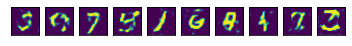

Epoch: [ 2] [  50/ 468] D_loss: 0.31205267, G_loss: 0.31931221
Epoch: [ 2] [ 100/ 468] D_loss: 0.30037493, G_loss: 0.31114328
Epoch: [ 2] [ 150/ 468] D_loss: 0.31752187, G_loss: 0.30829927
Epoch: [ 2] [ 200/ 468] D_loss: 0.30848539, G_loss: 0.31193650
Epoch: [ 2] [ 250/ 468] D_loss: 0.31670418, G_loss: 0.31636816
Epoch: [ 2] [ 300/ 468] D_loss: 0.31147906, G_loss: 0.34439349
Epoch: [ 2] [ 350/ 468] D_loss: 0.30354902, G_loss: 0.31414467
Epoch: [ 2] [ 400/ 468] D_loss: 0.35527658, G_loss: 0.29565531
Epoch: [ 2] [ 450/ 468] D_loss: 0.29878372, G_loss: 0.33764541


<Figure size 72x720 with 0 Axes>

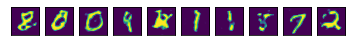

Epoch: [ 3] [  50/ 468] D_loss: 0.33026913, G_loss: 0.30951643
Epoch: [ 3] [ 100/ 468] D_loss: 0.31340200, G_loss: 0.31686637
Epoch: [ 3] [ 150/ 468] D_loss: 0.32318577, G_loss: 0.31195849
Epoch: [ 3] [ 200/ 468] D_loss: 0.31391731, G_loss: 0.32845548
Epoch: [ 3] [ 250/ 468] D_loss: 0.30157036, G_loss: 0.30830407
Epoch: [ 3] [ 300/ 468] D_loss: 0.30728129, G_loss: 0.32941154
Epoch: [ 3] [ 350/ 468] D_loss: 0.35276365, G_loss: 0.33205488
Epoch: [ 3] [ 400/ 468] D_loss: 0.31574097, G_loss: 0.30170354
Epoch: [ 3] [ 450/ 468] D_loss: 0.31404424, G_loss: 0.33900511


<Figure size 72x720 with 0 Axes>

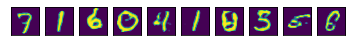

Epoch: [ 4] [  50/ 468] D_loss: 0.32050878, G_loss: 0.34352654
Epoch: [ 4] [ 100/ 468] D_loss: 0.31222245, G_loss: 0.30760238
Epoch: [ 4] [ 150/ 468] D_loss: 0.30572116, G_loss: 0.31124243
Epoch: [ 4] [ 200/ 468] D_loss: 0.31457916, G_loss: 0.33509928
Epoch: [ 4] [ 250/ 468] D_loss: 0.33488682, G_loss: 0.32656443
Epoch: [ 4] [ 300/ 468] D_loss: 0.33388537, G_loss: 0.30561942
Epoch: [ 4] [ 350/ 468] D_loss: 0.35893852, G_loss: 0.33988085
Epoch: [ 4] [ 400/ 468] D_loss: 0.29822177, G_loss: 0.34361672
Epoch: [ 4] [ 450/ 468] D_loss: 0.32411414, G_loss: 0.36134687


<Figure size 72x720 with 0 Axes>

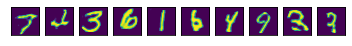

Epoch: [ 5] [  50/ 468] D_loss: 0.32443023, G_loss: 0.35914221
Epoch: [ 5] [ 100/ 468] D_loss: 0.30006462, G_loss: 0.35835516
Epoch: [ 5] [ 150/ 468] D_loss: 0.29354322, G_loss: 0.33951867
Epoch: [ 5] [ 200/ 468] D_loss: 0.33276016, G_loss: 0.36155742
Epoch: [ 5] [ 250/ 468] D_loss: 0.35806900, G_loss: 0.24957286
Epoch: [ 5] [ 300/ 468] D_loss: 0.34093058, G_loss: 0.31488684
Epoch: [ 5] [ 350/ 468] D_loss: 0.31581226, G_loss: 0.33489400
Epoch: [ 5] [ 400/ 468] D_loss: 0.29957098, G_loss: 0.33074829
Epoch: [ 5] [ 450/ 468] D_loss: 0.30013001, G_loss: 0.36991584


<Figure size 72x720 with 0 Axes>

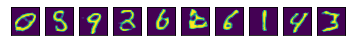

Epoch: [ 6] [  50/ 468] D_loss: 0.30773908, G_loss: 0.36232382
Epoch: [ 6] [ 100/ 468] D_loss: 0.32836384, G_loss: 0.32954514
Epoch: [ 6] [ 150/ 468] D_loss: 0.31572440, G_loss: 0.32498646
Epoch: [ 6] [ 200/ 468] D_loss: 0.29857010, G_loss: 0.35024559
Epoch: [ 6] [ 250/ 468] D_loss: 0.29899526, G_loss: 0.36559460
Epoch: [ 6] [ 300/ 468] D_loss: 0.26939136, G_loss: 0.38392675
Epoch: [ 6] [ 350/ 468] D_loss: 0.30239537, G_loss: 0.38419235
Epoch: [ 6] [ 400/ 468] D_loss: 0.29337969, G_loss: 0.33483064
Epoch: [ 6] [ 450/ 468] D_loss: 0.29957092, G_loss: 0.34917420


<Figure size 72x720 with 0 Axes>

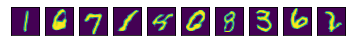

Epoch: [ 7] [  50/ 468] D_loss: 0.28779012, G_loss: 0.34850371
Epoch: [ 7] [ 100/ 468] D_loss: 0.26975778, G_loss: 0.35884398
Epoch: [ 7] [ 150/ 468] D_loss: 0.32007098, G_loss: 0.37044066
Epoch: [ 7] [ 200/ 468] D_loss: 0.33265513, G_loss: 0.36693153
Epoch: [ 7] [ 250/ 468] D_loss: 0.25125515, G_loss: 0.31799406
Epoch: [ 7] [ 300/ 468] D_loss: 0.30761701, G_loss: 0.30291691
Epoch: [ 7] [ 350/ 468] D_loss: 0.27505910, G_loss: 0.41486785
Epoch: [ 7] [ 400/ 468] D_loss: 0.31336850, G_loss: 0.38016063
Epoch: [ 7] [ 450/ 468] D_loss: 0.31812212, G_loss: 0.46225435


<Figure size 72x720 with 0 Axes>

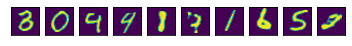

Epoch: [ 8] [  50/ 468] D_loss: 0.35270816, G_loss: 0.33889842
Epoch: [ 8] [ 100/ 468] D_loss: 0.25836021, G_loss: 0.38583577
Epoch: [ 8] [ 150/ 468] D_loss: 0.25916928, G_loss: 0.44306508
Epoch: [ 8] [ 200/ 468] D_loss: 0.28653941, G_loss: 0.38567525
Epoch: [ 8] [ 250/ 468] D_loss: 0.24916303, G_loss: 0.32843339
Epoch: [ 8] [ 300/ 468] D_loss: 0.30326170, G_loss: 0.34441838
Epoch: [ 8] [ 350/ 468] D_loss: 0.29251033, G_loss: 0.40310943
Epoch: [ 8] [ 400/ 468] D_loss: 0.28006983, G_loss: 0.43661952
Epoch: [ 8] [ 450/ 468] D_loss: 0.28116906, G_loss: 0.36819351


<Figure size 72x720 with 0 Axes>

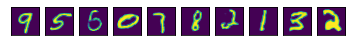

Epoch: [ 9] [  50/ 468] D_loss: 0.27346087, G_loss: 0.40388063
Epoch: [ 9] [ 100/ 468] D_loss: 0.26256859, G_loss: 0.32872534
Epoch: [ 9] [ 150/ 468] D_loss: 0.23771739, G_loss: 0.38324773
Epoch: [ 9] [ 200/ 468] D_loss: 0.26188350, G_loss: 0.38980341
Epoch: [ 9] [ 250/ 468] D_loss: 0.26323959, G_loss: 0.42814589
Epoch: [ 9] [ 300/ 468] D_loss: 0.29741925, G_loss: 0.47969052
Epoch: [ 9] [ 350/ 468] D_loss: 0.26264685, G_loss: 0.40219343
Epoch: [ 9] [ 400/ 468] D_loss: 0.23778600, G_loss: 0.37260288
Epoch: [ 9] [ 450/ 468] D_loss: 0.23488671, G_loss: 0.41472268


<Figure size 72x720 with 0 Axes>

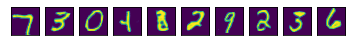

Epoch: [10] [  50/ 468] D_loss: 0.23767763, G_loss: 0.35017782
Epoch: [10] [ 100/ 468] D_loss: 0.26363906, G_loss: 0.27482054
Epoch: [10] [ 150/ 468] D_loss: 0.24901983, G_loss: 0.33317578
Epoch: [10] [ 200/ 468] D_loss: 0.27703062, G_loss: 0.44091052
Epoch: [10] [ 250/ 468] D_loss: 0.27226552, G_loss: 0.31208768
Epoch: [10] [ 300/ 468] D_loss: 0.24554621, G_loss: 0.44362199
Epoch: [10] [ 350/ 468] D_loss: 0.28123838, G_loss: 0.25320131
Epoch: [10] [ 400/ 468] D_loss: 0.24830063, G_loss: 0.37181211
Epoch: [10] [ 450/ 468] D_loss: 0.20874408, G_loss: 0.42951292


<Figure size 72x720 with 0 Axes>

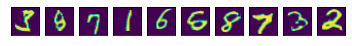

Epoch: [11] [  50/ 468] D_loss: 0.26987630, G_loss: 0.35635000
Epoch: [11] [ 100/ 468] D_loss: 0.25382644, G_loss: 0.45207086
Epoch: [11] [ 150/ 468] D_loss: 0.20972836, G_loss: 0.31753951
Epoch: [11] [ 200/ 468] D_loss: 0.24293038, G_loss: 0.50940120
Epoch: [11] [ 250/ 468] D_loss: 0.27513015, G_loss: 0.39665407
Epoch: [11] [ 300/ 468] D_loss: 0.25268885, G_loss: 0.29077348
Epoch: [11] [ 350/ 468] D_loss: 0.24478142, G_loss: 0.41473487
Epoch: [11] [ 400/ 468] D_loss: 0.22781914, G_loss: 0.31185639
Epoch: [11] [ 450/ 468] D_loss: 0.21363892, G_loss: 0.41796005


<Figure size 72x720 with 0 Axes>

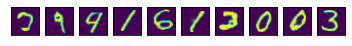

Epoch: [12] [  50/ 468] D_loss: 0.23224437, G_loss: 0.41746214
Epoch: [12] [ 100/ 468] D_loss: 0.22989491, G_loss: 0.33701220
Epoch: [12] [ 150/ 468] D_loss: 0.17700404, G_loss: 0.51532847
Epoch: [12] [ 200/ 468] D_loss: 0.27559668, G_loss: 0.46359751
Epoch: [12] [ 250/ 468] D_loss: 0.25412869, G_loss: 0.45636836
Epoch: [12] [ 300/ 468] D_loss: 0.24192622, G_loss: 0.43710420
Epoch: [12] [ 350/ 468] D_loss: 0.22940959, G_loss: 0.40024966
Epoch: [12] [ 400/ 468] D_loss: 0.23576592, G_loss: 0.47714308
Epoch: [12] [ 450/ 468] D_loss: 0.21580522, G_loss: 0.34127265


<Figure size 72x720 with 0 Axes>

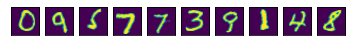

Epoch: [13] [  50/ 468] D_loss: 0.25343782, G_loss: 0.46485418
Epoch: [13] [ 100/ 468] D_loss: 0.27371293, G_loss: 0.43414882
Epoch: [13] [ 150/ 468] D_loss: 0.24761313, G_loss: 0.46097258
Epoch: [13] [ 200/ 468] D_loss: 0.22378317, G_loss: 0.50932556
Epoch: [13] [ 250/ 468] D_loss: 0.19844033, G_loss: 0.49440151
Epoch: [13] [ 300/ 468] D_loss: 0.19787206, G_loss: 0.48618740
Epoch: [13] [ 350/ 468] D_loss: 0.28670916, G_loss: 0.35646045
Epoch: [13] [ 400/ 468] D_loss: 0.28228593, G_loss: 0.47333562
Epoch: [13] [ 450/ 468] D_loss: 0.21224812, G_loss: 0.46106303


<Figure size 72x720 with 0 Axes>

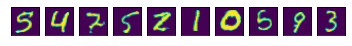

Epoch: [14] [  50/ 468] D_loss: 0.18812796, G_loss: 0.54929978
Epoch: [14] [ 100/ 468] D_loss: 0.19363186, G_loss: 0.50566810
Epoch: [14] [ 150/ 468] D_loss: 0.19303508, G_loss: 0.42701447
Epoch: [14] [ 200/ 468] D_loss: 0.19947821, G_loss: 0.31634265
Epoch: [14] [ 250/ 468] D_loss: 0.21627149, G_loss: 0.42267051
Epoch: [14] [ 300/ 468] D_loss: 0.20862001, G_loss: 0.44753549
Epoch: [14] [ 350/ 468] D_loss: 0.18904619, G_loss: 0.41529828
Epoch: [14] [ 400/ 468] D_loss: 0.24320278, G_loss: 0.44038665
Epoch: [14] [ 450/ 468] D_loss: 0.21341041, G_loss: 0.44628680


<Figure size 72x720 with 0 Axes>

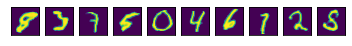

Epoch: [15] [  50/ 468] D_loss: 0.18981713, G_loss: 0.49964967
Epoch: [15] [ 100/ 468] D_loss: 0.26305595, G_loss: 0.47105178
Epoch: [15] [ 150/ 468] D_loss: 0.27326488, G_loss: 0.39173740
Epoch: [15] [ 200/ 468] D_loss: 0.26754588, G_loss: 0.51750004
Epoch: [15] [ 250/ 468] D_loss: 0.22877543, G_loss: 0.34194973
Epoch: [15] [ 300/ 468] D_loss: 0.18420371, G_loss: 0.54515243
Epoch: [15] [ 350/ 468] D_loss: 0.21001786, G_loss: 0.46116018
Epoch: [15] [ 400/ 468] D_loss: 0.23457983, G_loss: 0.53734314
Epoch: [15] [ 450/ 468] D_loss: 0.14964306, G_loss: 0.42474484


<Figure size 72x720 with 0 Axes>

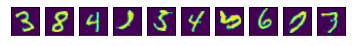

Epoch: [16] [  50/ 468] D_loss: 0.17798182, G_loss: 0.44158414
Epoch: [16] [ 100/ 468] D_loss: 0.17762810, G_loss: 0.48928863
Epoch: [16] [ 150/ 468] D_loss: 0.19401920, G_loss: 0.55689114
Epoch: [16] [ 200/ 468] D_loss: 0.16521227, G_loss: 0.55177039
Epoch: [16] [ 250/ 468] D_loss: 0.21203983, G_loss: 0.35898244
Epoch: [16] [ 300/ 468] D_loss: 0.20067963, G_loss: 0.54840553
Epoch: [16] [ 350/ 468] D_loss: 0.23517068, G_loss: 0.37666550
Epoch: [16] [ 400/ 468] D_loss: 0.20951416, G_loss: 0.41050255
Epoch: [16] [ 450/ 468] D_loss: 0.20220734, G_loss: 0.47720978


<Figure size 72x720 with 0 Axes>

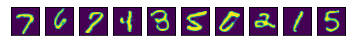

Epoch: [17] [  50/ 468] D_loss: 0.18364811, G_loss: 0.35046050
Epoch: [17] [ 100/ 468] D_loss: 0.13775800, G_loss: 0.41510835
Epoch: [17] [ 150/ 468] D_loss: 0.16711479, G_loss: 0.47086957
Epoch: [17] [ 200/ 468] D_loss: 0.22862798, G_loss: 0.41012120
Epoch: [17] [ 250/ 468] D_loss: 0.20280123, G_loss: 0.44074064
Epoch: [17] [ 300/ 468] D_loss: 0.23394921, G_loss: 0.51106226
Epoch: [17] [ 350/ 468] D_loss: 0.20693761, G_loss: 0.44184798
Epoch: [17] [ 400/ 468] D_loss: 0.19518982, G_loss: 0.44628495
Epoch: [17] [ 450/ 468] D_loss: 0.17363980, G_loss: 0.47855800


<Figure size 72x720 with 0 Axes>

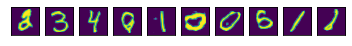

Epoch: [18] [  50/ 468] D_loss: 0.18168969, G_loss: 0.37673581
Epoch: [18] [ 100/ 468] D_loss: 0.17668307, G_loss: 0.54910004
Epoch: [18] [ 150/ 468] D_loss: 0.17488360, G_loss: 0.52932358
Epoch: [18] [ 200/ 468] D_loss: 0.14827460, G_loss: 0.53354323
Epoch: [18] [ 250/ 468] D_loss: 0.22474721, G_loss: 0.45153502
Epoch: [18] [ 300/ 468] D_loss: 0.14826843, G_loss: 0.54195321
Epoch: [18] [ 350/ 468] D_loss: 0.23942068, G_loss: 0.36655390
Epoch: [18] [ 400/ 468] D_loss: 0.16134286, G_loss: 0.27917749
Epoch: [18] [ 450/ 468] D_loss: 0.14883554, G_loss: 0.52346647


<Figure size 72x720 with 0 Axes>

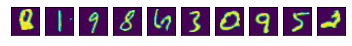

Epoch: [19] [  50/ 468] D_loss: 0.14355528, G_loss: 0.57968354
Epoch: [19] [ 100/ 468] D_loss: 0.16286668, G_loss: 0.57366824
Epoch: [19] [ 150/ 468] D_loss: 0.20528737, G_loss: 0.55142003
Epoch: [19] [ 200/ 468] D_loss: 0.18022656, G_loss: 0.58122820
Epoch: [19] [ 250/ 468] D_loss: 0.17602684, G_loss: 0.49495524
Epoch: [19] [ 300/ 468] D_loss: 0.14653265, G_loss: 0.53484738
Epoch: [19] [ 350/ 468] D_loss: 0.19270463, G_loss: 0.37775925
Epoch: [19] [ 400/ 468] D_loss: 0.20719916, G_loss: 0.52588224
Epoch: [19] [ 450/ 468] D_loss: 0.18191981, G_loss: 0.44208038


<Figure size 72x720 with 0 Axes>

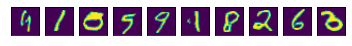

Epoch: [20] [  50/ 468] D_loss: 0.14516683, G_loss: 0.52225411
Epoch: [20] [ 100/ 468] D_loss: 0.22325879, G_loss: 0.49692032
Epoch: [20] [ 150/ 468] D_loss: 0.15598404, G_loss: 0.54994762
Epoch: [20] [ 200/ 468] D_loss: 0.13075989, G_loss: 0.48251304
Epoch: [20] [ 250/ 468] D_loss: 0.19169782, G_loss: 0.60224140
Epoch: [20] [ 300/ 468] D_loss: 0.12032210, G_loss: 0.55211139
Epoch: [20] [ 350/ 468] D_loss: 0.18417889, G_loss: 0.41742787
Epoch: [20] [ 400/ 468] D_loss: 0.17848963, G_loss: 0.45555520
Epoch: [20] [ 450/ 468] D_loss: 0.14505078, G_loss: 0.32581478


<Figure size 72x720 with 0 Axes>

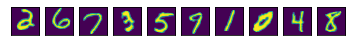

Epoch: [21] [  50/ 468] D_loss: 0.12976299, G_loss: 0.52868122
Epoch: [21] [ 100/ 468] D_loss: 0.20066178, G_loss: 0.50224757
Epoch: [21] [ 150/ 468] D_loss: 0.27074301, G_loss: 0.41188696
Epoch: [21] [ 200/ 468] D_loss: 0.17502905, G_loss: 0.61046392
Epoch: [21] [ 250/ 468] D_loss: 0.14778556, G_loss: 0.51183194
Epoch: [21] [ 300/ 468] D_loss: 0.18335956, G_loss: 0.42878175
Epoch: [21] [ 350/ 468] D_loss: 0.15496626, G_loss: 0.51906955
Epoch: [21] [ 400/ 468] D_loss: 0.17924508, G_loss: 0.57765782
Epoch: [21] [ 450/ 468] D_loss: 0.21188851, G_loss: 0.57634711


<Figure size 72x720 with 0 Axes>

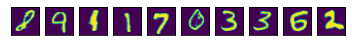

Epoch: [22] [  50/ 468] D_loss: 0.13166508, G_loss: 0.51491523
Epoch: [22] [ 100/ 468] D_loss: 0.10117619, G_loss: 0.57217777
Epoch: [22] [ 150/ 468] D_loss: 0.19082351, G_loss: 0.59999681
Epoch: [22] [ 200/ 468] D_loss: 0.14096615, G_loss: 0.43579137
Epoch: [22] [ 250/ 468] D_loss: 0.21495301, G_loss: 0.35321817
Epoch: [22] [ 300/ 468] D_loss: 0.15158445, G_loss: 0.58417982
Epoch: [22] [ 350/ 468] D_loss: 0.16672733, G_loss: 0.35471797
Epoch: [22] [ 400/ 468] D_loss: 0.14108157, G_loss: 0.57176089
Epoch: [22] [ 450/ 468] D_loss: 0.10496139, G_loss: 0.53402364


<Figure size 72x720 with 0 Axes>

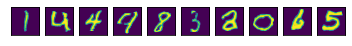

Epoch: [23] [  50/ 468] D_loss: 0.15826316, G_loss: 0.52724028
Epoch: [23] [ 100/ 468] D_loss: 0.12643479, G_loss: 0.62068474
Epoch: [23] [ 150/ 468] D_loss: 0.14088883, G_loss: 0.46266878
Epoch: [23] [ 200/ 468] D_loss: 0.15714148, G_loss: 0.60068548
Epoch: [23] [ 250/ 468] D_loss: 0.13636011, G_loss: 0.50641274
Epoch: [23] [ 300/ 468] D_loss: 0.19843446, G_loss: 0.52875948
Epoch: [23] [ 350/ 468] D_loss: 0.16149074, G_loss: 0.65773547
Epoch: [23] [ 400/ 468] D_loss: 0.16798061, G_loss: 0.53899443
Epoch: [23] [ 450/ 468] D_loss: 0.20599893, G_loss: 0.47883767


<Figure size 72x720 with 0 Axes>

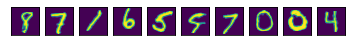

Epoch: [24] [  50/ 468] D_loss: 0.11773377, G_loss: 0.46231404
Epoch: [24] [ 100/ 468] D_loss: 0.13751093, G_loss: 0.52535748
Epoch: [24] [ 150/ 468] D_loss: 0.11119062, G_loss: 0.55834699
Epoch: [24] [ 200/ 468] D_loss: 0.16781300, G_loss: 0.55254966
Epoch: [24] [ 250/ 468] D_loss: 0.15412021, G_loss: 0.52628100
Epoch: [24] [ 300/ 468] D_loss: 0.13586135, G_loss: 0.53164268
Epoch: [24] [ 350/ 468] D_loss: 0.15293276, G_loss: 0.51689821
Epoch: [24] [ 400/ 468] D_loss: 0.11500567, G_loss: 0.56470156
Epoch: [24] [ 450/ 468] D_loss: 0.19925079, G_loss: 0.45476073


<Figure size 72x720 with 0 Axes>

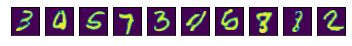

Epoch: [25] [  50/ 468] D_loss: 0.14390768, G_loss: 0.48201370
Epoch: [25] [ 100/ 468] D_loss: 0.13549152, G_loss: 0.43530816
Epoch: [25] [ 150/ 468] D_loss: 0.16102977, G_loss: 0.63713670
Epoch: [25] [ 200/ 468] D_loss: 0.17596650, G_loss: 0.42033255
Epoch: [25] [ 250/ 468] D_loss: 0.14437188, G_loss: 0.57831752
Epoch: [25] [ 300/ 468] D_loss: 0.16765605, G_loss: 0.33141410
Epoch: [25] [ 350/ 468] D_loss: 0.12044825, G_loss: 0.54735005
Epoch: [25] [ 400/ 468] D_loss: 0.14369406, G_loss: 0.63033080
Epoch: [25] [ 450/ 468] D_loss: 0.13584469, G_loss: 0.66893154


<Figure size 72x720 with 0 Axes>

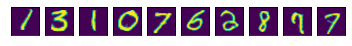

Epoch: [26] [  50/ 468] D_loss: 0.15523633, G_loss: 0.46933007
Epoch: [26] [ 100/ 468] D_loss: 0.13265762, G_loss: 0.46760780
Epoch: [26] [ 150/ 468] D_loss: 0.13757446, G_loss: 0.67286551
Epoch: [26] [ 200/ 468] D_loss: 0.14056513, G_loss: 0.48719871
Epoch: [26] [ 250/ 468] D_loss: 0.12408046, G_loss: 0.61796862
Epoch: [26] [ 300/ 468] D_loss: 0.12932552, G_loss: 0.62275356
Epoch: [26] [ 350/ 468] D_loss: 0.12061995, G_loss: 0.51310617
Epoch: [26] [ 400/ 468] D_loss: 0.20425835, G_loss: 0.45271987
Epoch: [26] [ 450/ 468] D_loss: 0.17983639, G_loss: 0.39369953


<Figure size 72x720 with 0 Axes>

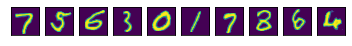

Epoch: [27] [  50/ 468] D_loss: 0.20104125, G_loss: 0.57235992
Epoch: [27] [ 100/ 468] D_loss: 0.11157171, G_loss: 0.58659959
Epoch: [27] [ 150/ 468] D_loss: 0.12920597, G_loss: 0.53822267
Epoch: [27] [ 200/ 468] D_loss: 0.12750940, G_loss: 0.56621885
Epoch: [27] [ 250/ 468] D_loss: 0.13127929, G_loss: 0.61877030
Epoch: [27] [ 300/ 468] D_loss: 0.10078897, G_loss: 0.43343306
Epoch: [27] [ 350/ 468] D_loss: 0.14528096, G_loss: 0.60584664
Epoch: [27] [ 400/ 468] D_loss: 0.14832667, G_loss: 0.41482925
Epoch: [27] [ 450/ 468] D_loss: 0.14490025, G_loss: 0.46826753


<Figure size 72x720 with 0 Axes>

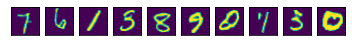

Epoch: [28] [  50/ 468] D_loss: 0.14770836, G_loss: 0.64492512
Epoch: [28] [ 100/ 468] D_loss: 0.12876588, G_loss: 0.66589803
Epoch: [28] [ 150/ 468] D_loss: 0.11969861, G_loss: 0.70641154
Epoch: [28] [ 200/ 468] D_loss: 0.16727859, G_loss: 0.35210291
Epoch: [28] [ 250/ 468] D_loss: 0.11177659, G_loss: 0.54430777
Epoch: [28] [ 300/ 468] D_loss: 0.13538639, G_loss: 0.62224686
Epoch: [28] [ 350/ 468] D_loss: 0.17188840, G_loss: 0.41672391
Epoch: [28] [ 400/ 468] D_loss: 0.18415500, G_loss: 0.70343310
Epoch: [28] [ 450/ 468] D_loss: 0.15602797, G_loss: 0.45113468


<Figure size 72x720 with 0 Axes>

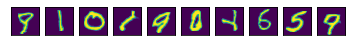

Epoch: [29] [  50/ 468] D_loss: 0.13665698, G_loss: 0.48050225
Epoch: [29] [ 100/ 468] D_loss: 0.10981955, G_loss: 0.54027790
Epoch: [29] [ 150/ 468] D_loss: 0.12030981, G_loss: 0.51105189
Epoch: [29] [ 200/ 468] D_loss: 0.15693687, G_loss: 0.43818372
Epoch: [29] [ 250/ 468] D_loss: 0.25639620, G_loss: 0.49495977
Epoch: [29] [ 300/ 468] D_loss: 0.11031399, G_loss: 0.60867673
Epoch: [29] [ 350/ 468] D_loss: 0.10741388, G_loss: 0.58427346
Epoch: [29] [ 400/ 468] D_loss: 0.10687684, G_loss: 0.63171613
Epoch: [29] [ 450/ 468] D_loss: 0.12115095, G_loss: 0.63776875


<Figure size 72x720 with 0 Axes>

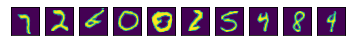

Epoch: [30] [  50/ 468] D_loss: 0.12609231, G_loss: 0.63325632
Epoch: [30] [ 100/ 468] D_loss: 0.10029233, G_loss: 0.62553990
Epoch: [30] [ 150/ 468] D_loss: 0.21869138, G_loss: 0.39828855
Epoch: [30] [ 200/ 468] D_loss: 0.17717190, G_loss: 0.60275555
Epoch: [30] [ 250/ 468] D_loss: 0.12520565, G_loss: 0.54247934
Epoch: [30] [ 300/ 468] D_loss: 0.17082822, G_loss: 0.57964194
Epoch: [30] [ 350/ 468] D_loss: 0.25709680, G_loss: 0.45827425
Epoch: [30] [ 400/ 468] D_loss: 0.09440374, G_loss: 0.61812818
Epoch: [30] [ 450/ 468] D_loss: 0.09741484, G_loss: 0.51178467


<Figure size 72x720 with 0 Axes>

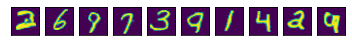

Training finished!


In [9]:
import time
params = {'beta1': 0.05, 'beta2': 0.999,'lr_g':0.0002,'lr_d':0.0002,'max_epochs':30}
params['z_dim'] =100
params['base_size'] = 128

gan = GAN(params)
gan.train()